In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Analysis of machine_meta csv - 

In [171]:
machine_meta = pd.read_csv('data/machine_meta.csv', header=None,
                           names=['machine_id','time_stamp','failure_domain_1',
                                  'failure_domain_2','cpu_num','mem_size','status'])
machine_meta.head()

,machine_id,time_stamp,failure_domain_1,failure_domain_2,cpu_num,mem_size,status
0,m_1,0,219,17.0,96,100,USING
1,m_1,148984,219,17.0,96,100,USING
2,m_1,535156,219,17.0,96,100,USING
3,m_1,552384,219,17.0,96,100,USING
4,m_1,658423,219,17.0,96,100,USING


# Analysis of machine_usage csv - 

Large File - Reading only 10,000,000 rows for now


In [172]:
# Reading 10 Million rows
machine_usage = pd.read_csv('data/machine_usage.csv', header=None, nrows=10000000, 
                            names=['machine_id','time_stamp','cpu_util_percent',
                                   'mem_util_percent','mem_gps','mkpi','net_in',
                                   'net_out','disk_io_percent'])

machine_usage = machine_usage.sort_values(by='time_stamp')
machine_usage

,machine_id,time_stamp,cpu_util_percent,mem_util_percent,mem_gps,mkpi,net_in,net_out,disk_io_percent
2806682,m_2344,0,25,92,NaN,NaN,42.77,35.94,2
6119265,m_2831,0,15,84,NaN,NaN,33.89,24.87,2
7872991,m_3089,0,7,88,NaN,NaN,29.93,20.88,1
4052389,m_2526,0,15,91,NaN,NaN,37.98,30.63,5
8946627,m_3246,0,6,84,NaN,NaN,35.14,26.58,2
...,...,...,...,...,...,...,...,...,...
5254641,m_2702,691190,29,96,4.39,0.0,50.47,40.22,3
4558952,m_2600,691190,91,96,0.64,0.0,47.52,38.75,5
2103537,m_2240,691190,23,93,NaN,NaN,60.98,51.17,5
3860638,m_2497,691190,25,95,3.68,0.0,50.31,35.75,2


## Hourly CPU & MEM Utilization Patterns - 

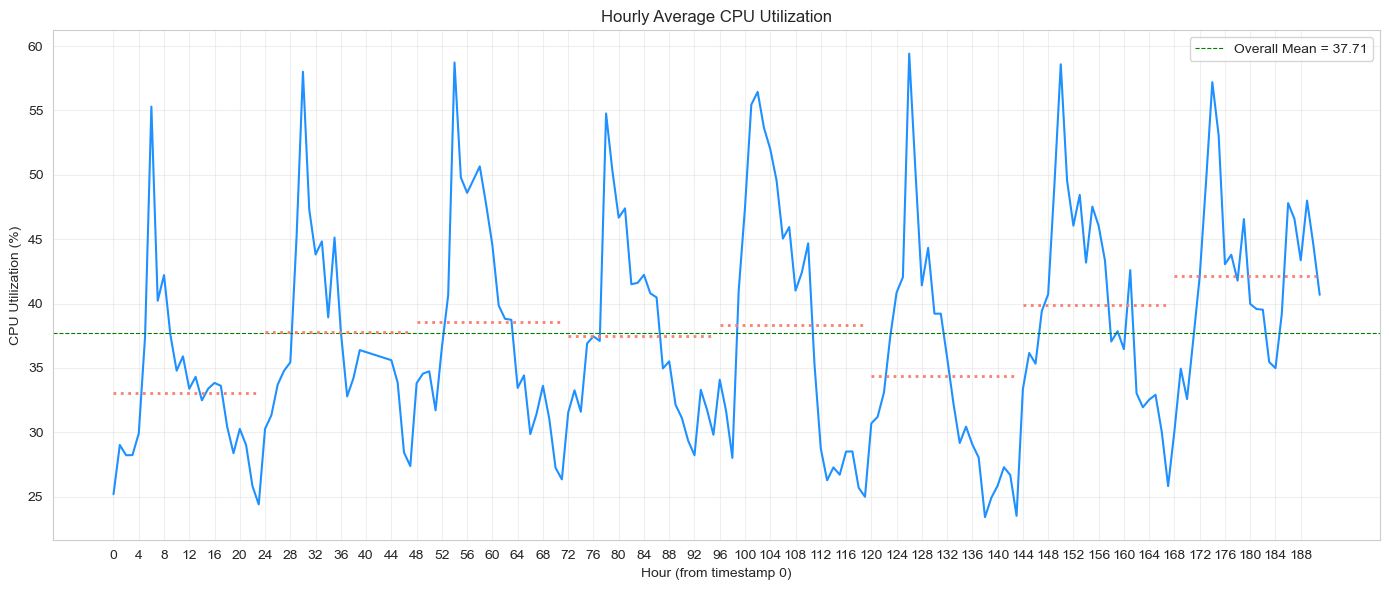

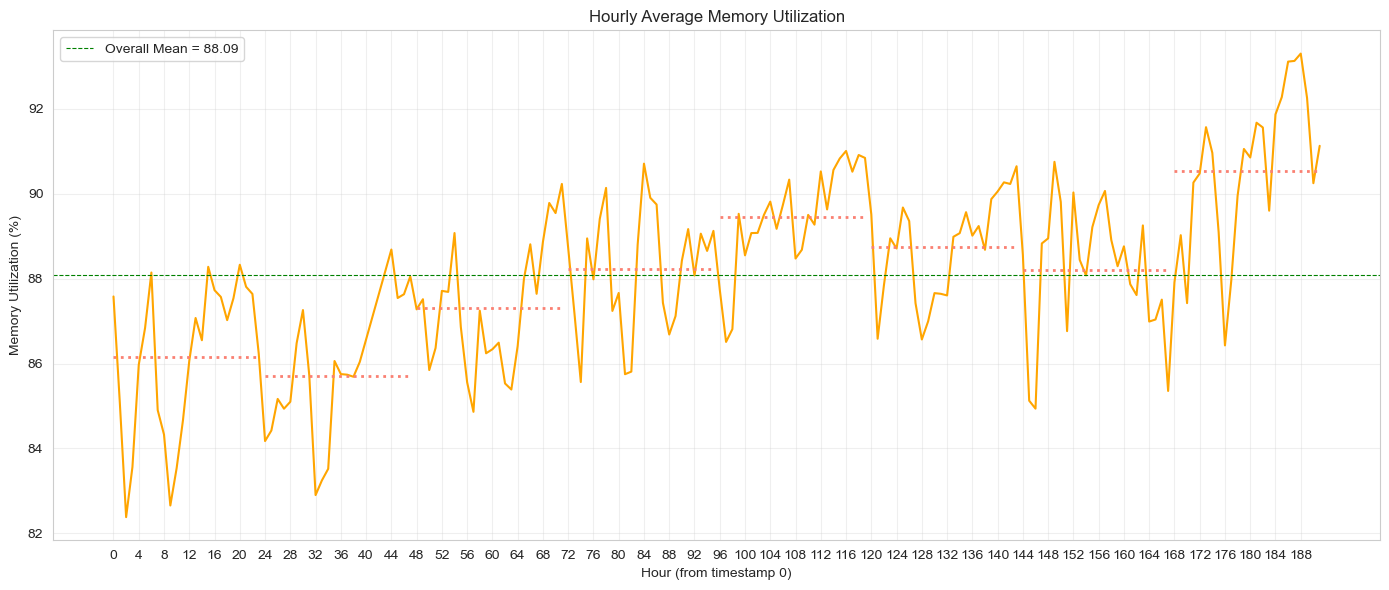

In [173]:
# Splitting data into hours
machine_usage['hour'] = machine_usage['time_stamp'] // 3600
# Calculating hourly averages
hourly_avg = machine_usage.groupby('hour')[['cpu_util_percent', 'mem_util_percent']].mean().reset_index()

def plot_with_24h_means(data, col_name, color, ylabel, title):
    plt.figure(figsize=(14, 6))
    plt.plot(data['hour'], data[col_name], color=color, linewidth=1.5)
    overall_mean = data[col_name].mean()
    plt.axhline(y=overall_mean, color='green', linestyle='--', linewidth=0.8, label=f'Overall Mean = {overall_mean:.2f}')
    
    max_hour = data['hour'].max()
    for start in range(0, max_hour + 1, 24):
        end = start + 24
        block = data[(data['hour'] >= start) & (data['hour'] < end)]
        if not block.empty:
            block_mean = block[col_name].mean()
            plt.hlines(y=block_mean, xmin=start, xmax=min(end - 1, max_hour), colors='salmon', linestyles='dotted', linewidth=2)

    plt.title(title)
    plt.xlabel('Hour (from timestamp 0)')
    plt.ylabel(ylabel)
    plt.xticks(ticks=np.arange(0, max_hour + 1, 4))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'alibaba_plots/Alibaba_{col_name}_plot')
    plt.show()

# Plotting CPU Utilization
plot_with_24h_means(data=hourly_avg, col_name='cpu_util_percent', color='dodgerblue', ylabel='CPU Utilization (%)', title='Hourly Average CPU Utilization')

# Plotting Memory Utilization
plot_with_24h_means(data=hourly_avg, col_name='mem_util_percent', color='orange', ylabel='Memory Utilization (%)', title='Hourly Average Memory Utilization')

## Machine Utilization Patterns -

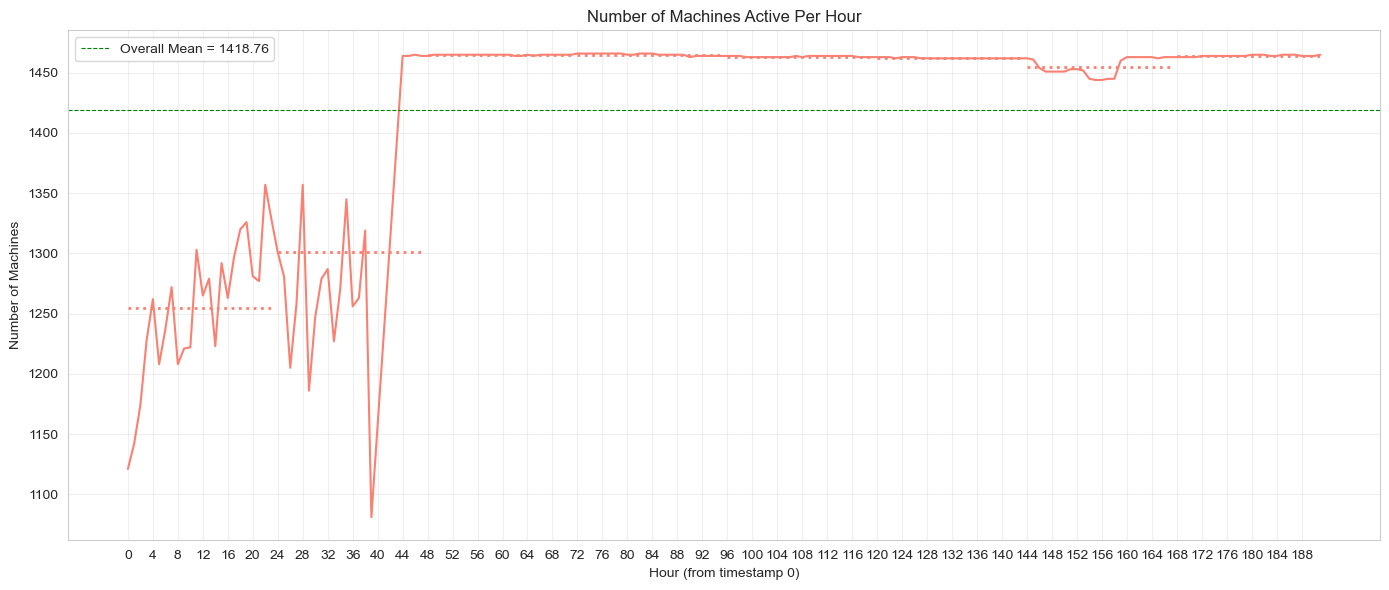

In [174]:
machines_per_hour = (machine_usage.groupby('hour')['machine_id'].nunique().reset_index(name='num_unique_machines'))
plot_with_24h_means(data=machines_per_hour, col_name='num_unique_machines', color='salmon', ylabel='Number of Machines', title='Number of Machines Active Per Hour')

## Incoming & Outgoing Traffic Patterns - 

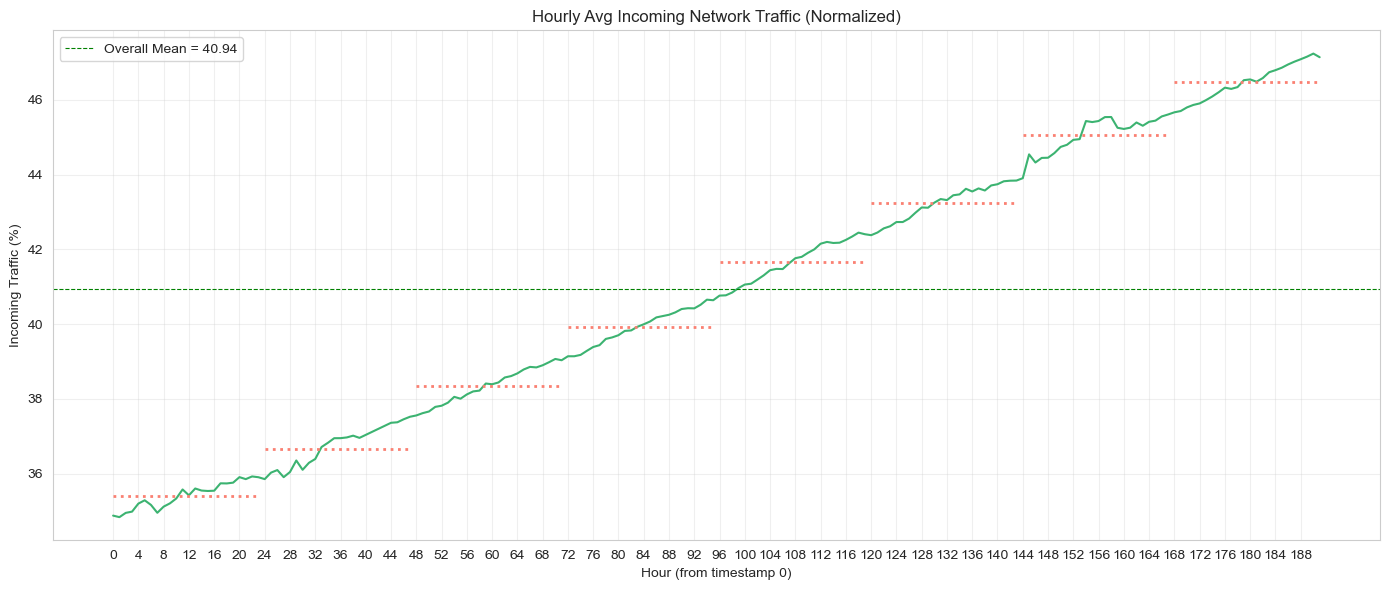

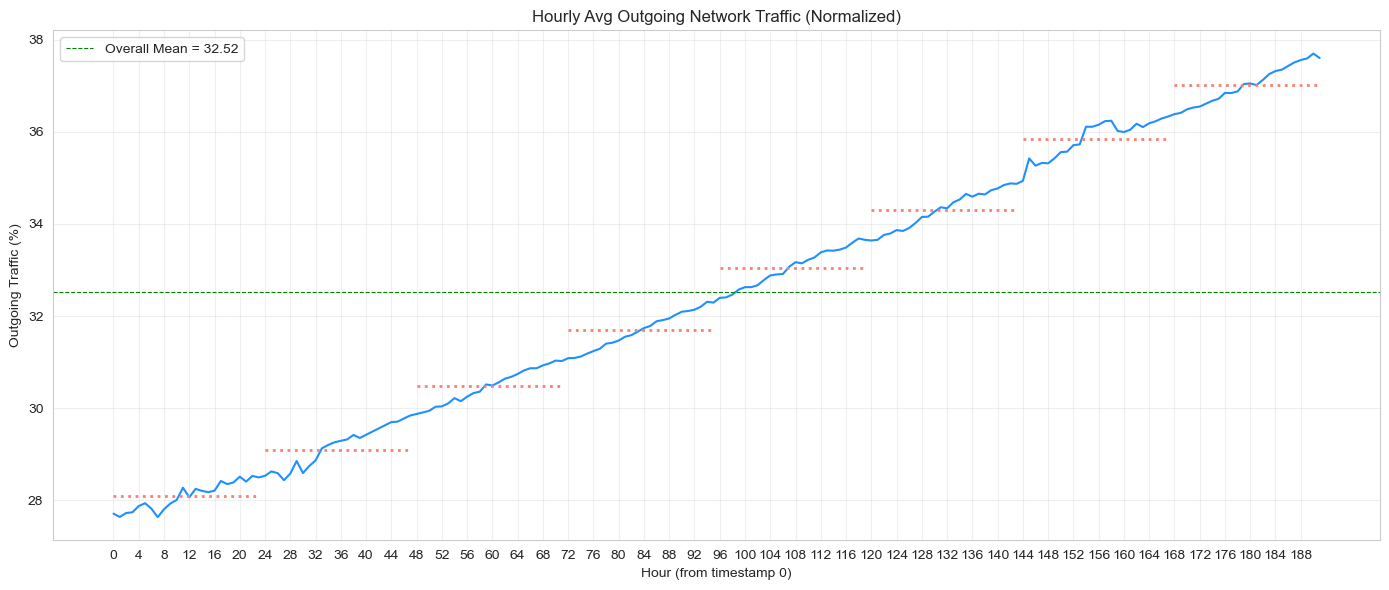

In [175]:
hourly_net = machine_usage.groupby('hour')[['net_in', 'net_out']].mean().reset_index()
plot_with_24h_means(data=hourly_net, col_name='net_in', color='mediumseagreen', ylabel='Incoming Traffic (%)', title='Hourly Avg Incoming Network Traffic (Normalized)')
plot_with_24h_means(data=hourly_net, col_name='net_out', color='dodgerblue', ylabel='Outgoing Traffic (%)', title='Hourly Avg Outgoing Network Traffic (Normalized)')

## Disk I/O Percent Patterns - 

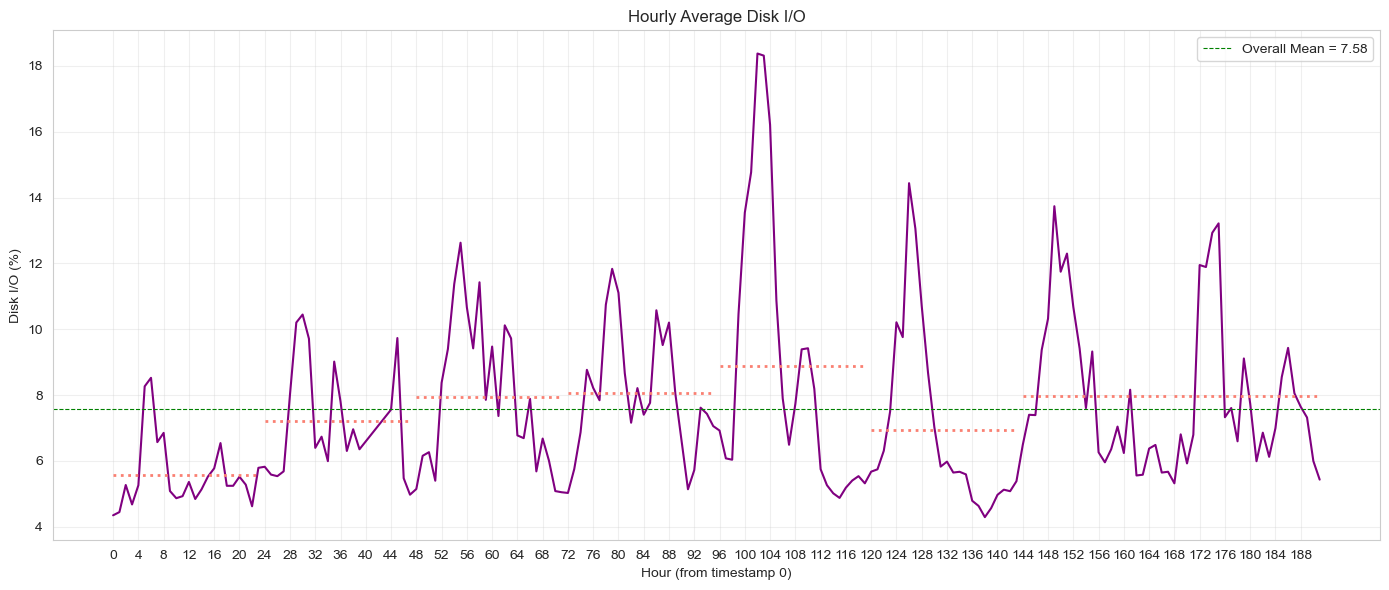

In [176]:
hourly_disk_io = machine_usage[(machine_usage['disk_io_percent'] >= 0) & (machine_usage['disk_io_percent'] <= 100)]
hourly_disk_io = hourly_disk_io.groupby('hour')[['disk_io_percent']].mean().reset_index()

plot_with_24h_means(data=hourly_disk_io, col_name='disk_io_percent', color='purple', ylabel='Disk I/O (%)', title='Hourly Average Disk I/O')

# Analysis of container_meta csv - 

In [177]:
container_meta = pd.read_csv('data/container_meta.csv', header=None, 
                              names=['container_id','machine_id', 'time_stamp','cpu_util_percent',
                                     'mem_util_percent','cpi','mem_gps','mpki','net_in','net_out',
                                     'disk_io_percent'])
container_meta.head()

,container_id,machine_id,time_stamp,cpu_util_percent,mem_util_percent,cpi,mem_gps,mpki,net_in,net_out,disk_io_percent
0,c_1,m_2556,0,app_5052,started,400,400,1.56,NaN,NaN,NaN
1,c_1,m_2556,287942,app_5052,started,400,400,1.56,NaN,NaN,NaN
2,c_1,m_2556,338909,app_5052,started,400,400,1.56,NaN,NaN,NaN
3,c_2,m_962,0,app_8125,started,800,800,3.13,NaN,NaN,NaN
4,c_2,m_962,23205,app_8125,started,800,800,3.13,NaN,NaN,NaN


# Analysis of batch_task csv - 

Large File - Reading only 10,000,000 rows for now

In [178]:
batch_task = pd.read_csv('data/batch_task.csv', header=None, nrows=10000000,
                         names=['task_name','instance_num','job_name','task_type',
                                'status','start_time_task','end_time_task','plan_cpu','plan_mem'])
batch_task.head()

,task_name,instance_num,job_name,task_type,status,start_time_task,end_time_task,plan_cpu,plan_mem
0,M1,1.0,j_1,1,Terminated,419912,419912,100.0,0.20
1,R2_1,1.0,j_2,1,Terminated,87076,87086,50.0,0.20
2,M1,1.0,j_2,1,Terminated,87076,87083,50.0,0.20
3,R6_3,371.0,j_3,1,Terminated,157297,157325,100.0,0.49
4,J4_2_3,1111.0,j_3,1,Terminated,157329,157376,100.0,0.59


In [179]:
running_tasks = batch_task[batch_task['status'] == 'Running']
running_tasks = running_tasks.sort_values(by=['start_time_task', 'end_time_task'])
running_tasks = running_tasks.dropna(subset=['plan_cpu', 'plan_mem'])
# Splitting data into hours
running_tasks['start_hour'] = running_tasks['start_time_task'] // 3600
running_tasks['end_hour'] = running_tasks['end_time_task'] // 3600
running_tasks = running_tasks[['task_name', 'task_type', 'plan_cpu', 'plan_mem','start_hour', 'end_hour']]
running_tasks

,task_name,task_type,plan_cpu,plan_mem,start_hour,end_hour
771712,J5_2_3_4,1,100.0,0.59,0,0
9948906,J5_4,1,50.0,0.59,0,0
1739122,J13_2_3_4_12,1,100.0,0.49,0,0
3950627,R2_1,1,100.0,0.59,5,66
9087632,J9_3_8,1,100.0,0.59,15,0
...,...,...,...,...,...,...
7950641,J8_5_7,1,50.0,0.39,191,192
7950645,J11_6_10,1,50.0,0.39,191,192
7950647,J9_3_4_8,1,50.0,0.39,191,192
7950648,J10_2_9,1,50.0,0.30,191,192


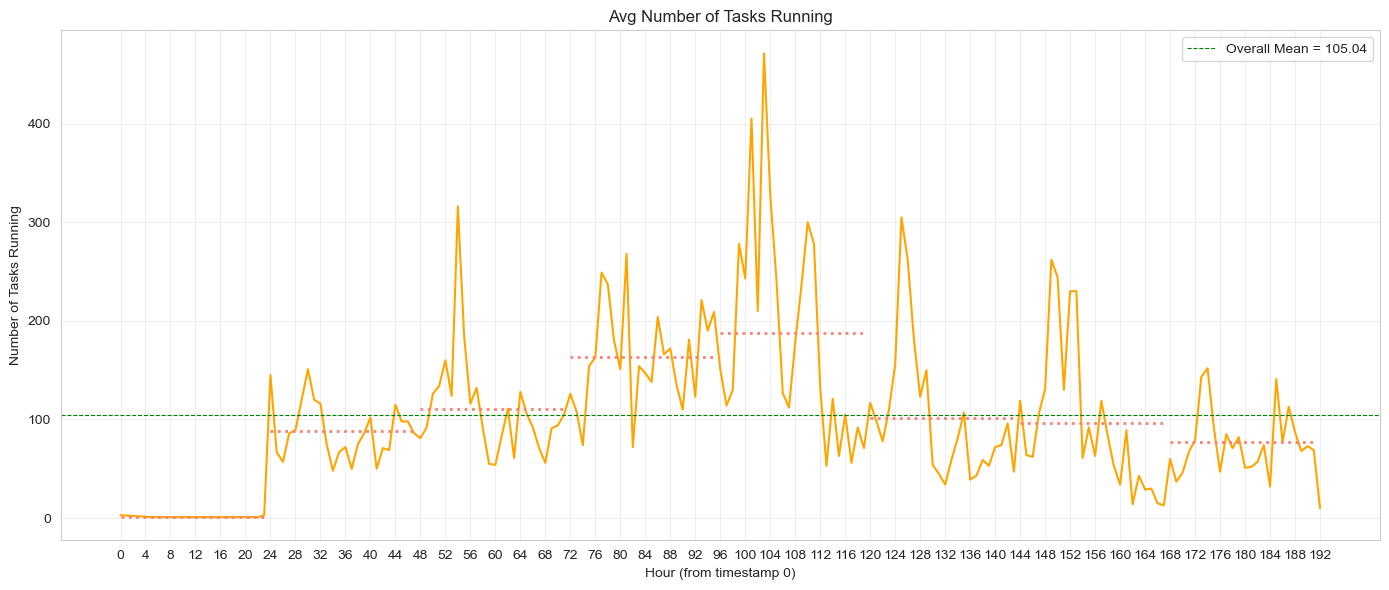

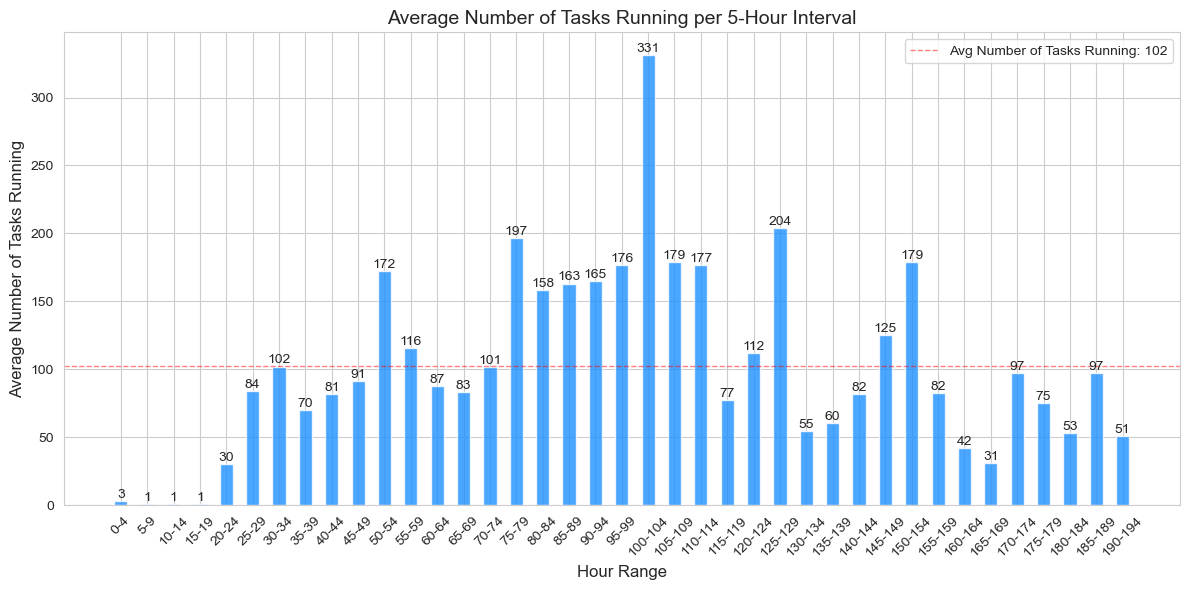

In [180]:
hourly_tasks = (running_tasks.assign(hour=lambda df: df.apply(lambda row: range(row['start_hour'], row['end_hour'] + 1), axis=1)).explode('hour'))
task_counts = (hourly_tasks.groupby(['hour'])['task_name'].nunique().reset_index(name='num_tasks'))
task_counts = task_counts.dropna(subset=['hour', 'num_tasks'])

plot_with_24h_means(data=task_counts, col_name='num_tasks', color='orange', ylabel='Number of Tasks Running', title='Avg Number of Tasks Running')
task_counts['interval'] = (task_counts['hour'] // 5) * 5
interval_avg = task_counts.groupby('interval')['num_tasks'].mean().reset_index()
overall_mean = interval_avg['num_tasks'].mean()

plt.figure(figsize=(12, 6))
bars = plt.bar([f"{int(x)}-{int(x)+4}" for x in interval_avg['interval']], interval_avg['num_tasks'], color='#1E90FF', alpha=0.8, width=0.5)
plt.axhline(y=overall_mean, color='red', linestyle='--', linewidth=1, label=f'Avg Number of Tasks Running: {round(overall_mean)}', alpha=0.5)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{round(bar.get_height())}', ha='center', va='bottom')

plt.title('Average Number of Tasks Running per 5-Hour Interval', fontsize=14)
plt.xlabel('Hour Range', fontsize=12)
plt.ylabel('Average Number of Tasks Running', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('alibaba_plots/Alibaba_num_tasks_bar')
plt.show()

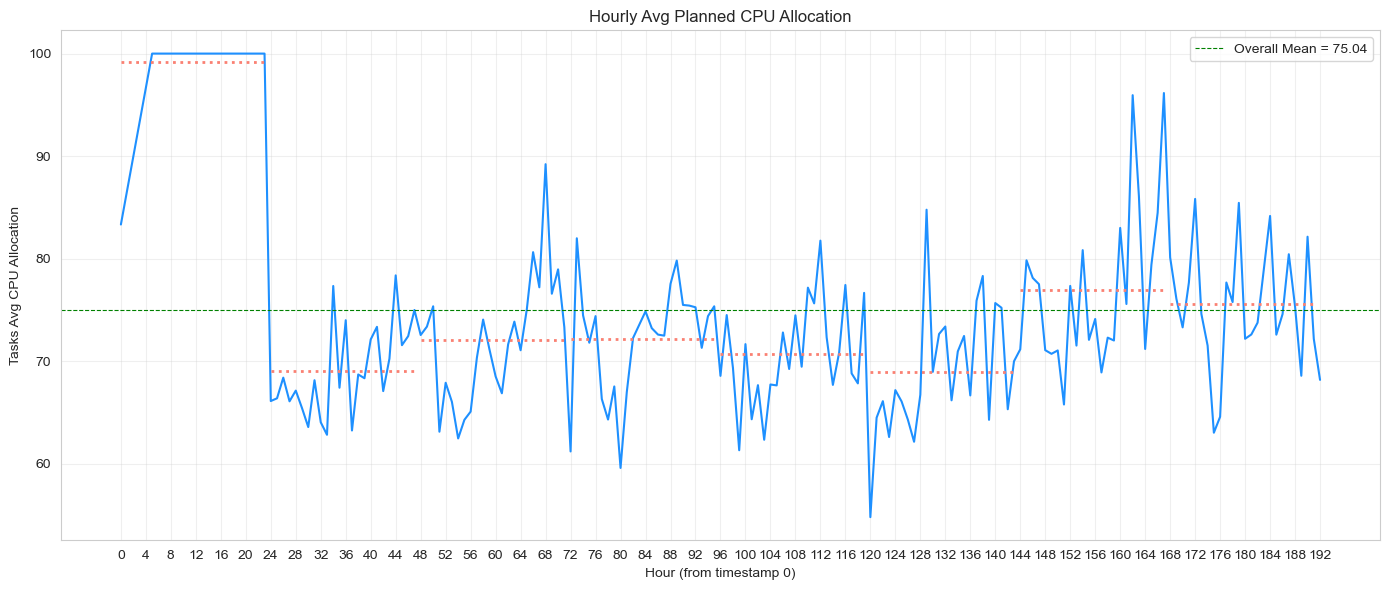

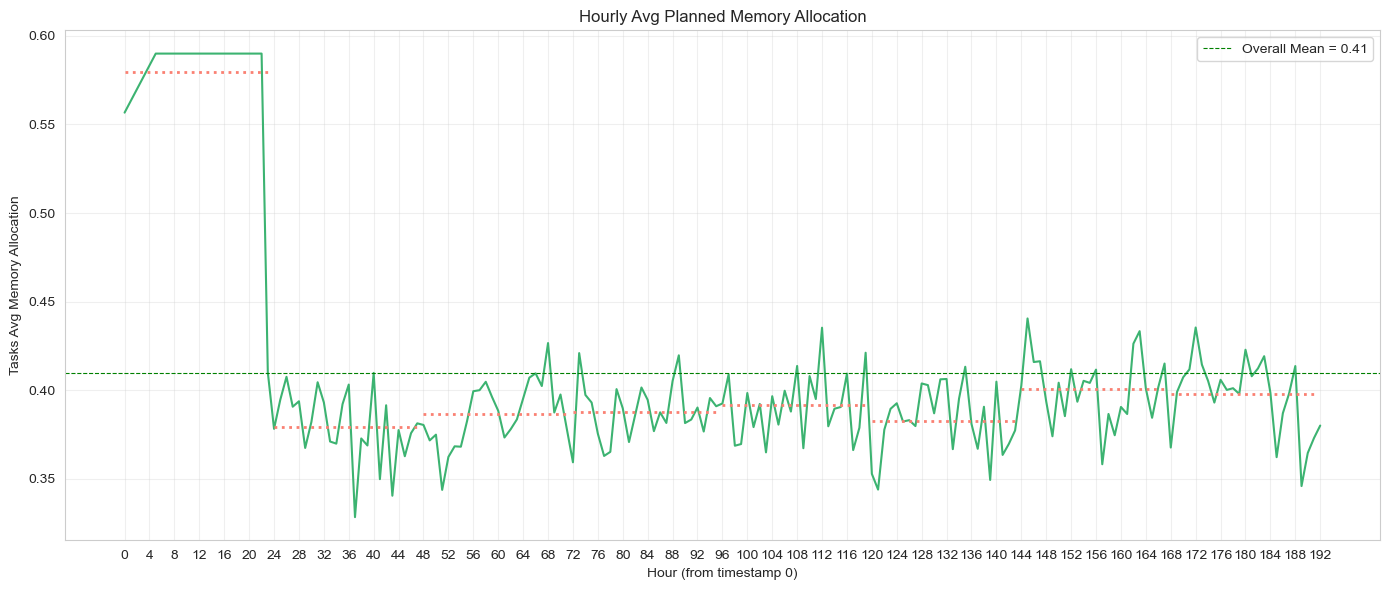

In [181]:
hourly_avg_plan = (hourly_tasks.groupby('hour')[['plan_cpu', 'plan_mem']].mean().reset_index())
plot_with_24h_means(data=hourly_avg_plan, col_name='plan_cpu', color='dodgerblue', ylabel='Tasks Avg CPU Allocation', title='Hourly Avg Planned CPU Allocation')
plot_with_24h_means(data=hourly_avg_plan, col_name='plan_mem', color='mediumseagreen', ylabel='Tasks Avg Memory Allocation', title='Hourly Avg Planned Memory Allocation')

Large File - Reading only 10,000,000 rows for now

In [186]:
batch_instance = pd.read_csv('batch_instance.csv', nrows=10000000, header=None,
                             names=['instance_name','task_name','job_name','task_type',
                                    'status','start_time_instance','end_time_instance','machine_id','seq_no',
                                    'total_seq_no','cpu_avg','cpu_max','mem_avg','mem_max'])

# 100 is 1 core
batch_instance['cpu_avg'] = batch_instance['cpu_avg'] / 100
batch_instance['cpu_max'] = batch_instance['cpu_max'] / 100
batch_instance.head()

,instance_name,task_name,job_name,task_type,status,start_time_instance,end_time_instance,machine_id,seq_no,total_seq_no,cpu_avg,cpu_max,mem_avg,mem_max
0,ins_74901673,task_LTg0MTUwNTA5Mjg4MDkwNjIzMA==,j_217,10,Terminated,673795,673797,m_2637,1,1,0.13,0.16,0.02,0.02
1,ins_815802872,M1,j_1527,1,Terminated,158478,158520,m_3430,1,1,0.03,0.19,0.13,0.18
2,ins_564677701,M1,j_2014,1,Terminated,372602,372616,m_1910,1,1,0.87,1.16,0.04,0.05
3,ins_257566161,M1,j_2014,1,Terminated,372602,372615,m_2485,1,1,0.91,1.23,0.05,0.05
4,ins_688679908,M1,j_2014,1,Terminated,372602,372615,m_993,1,1,0.93,1.41,0.05,0.05


In [194]:
task_type_resource_util = batch_instance.groupby('task_type')[['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']].mean().dropna()
task_type_resource_util

,cpu_avg,cpu_max,mem_avg,mem_max
task_type,,,,
1,0.610946,1.219036,0.108809,0.139747
3,0.768725,1.054004,0.041274,0.053690
4,0.102464,0.389420,0.040145,0.045797
6,0.161785,0.353880,0.020208,0.020978
8,0.423708,1.188524,0.130552,0.192390
9,0.839413,3.085573,0.139183,0.176315
10,0.706740,0.873049,0.052716,0.058338
11,0.781700,3.607632,0.075871,0.105504
12,0.772662,0.971840,0.137854,0.160420


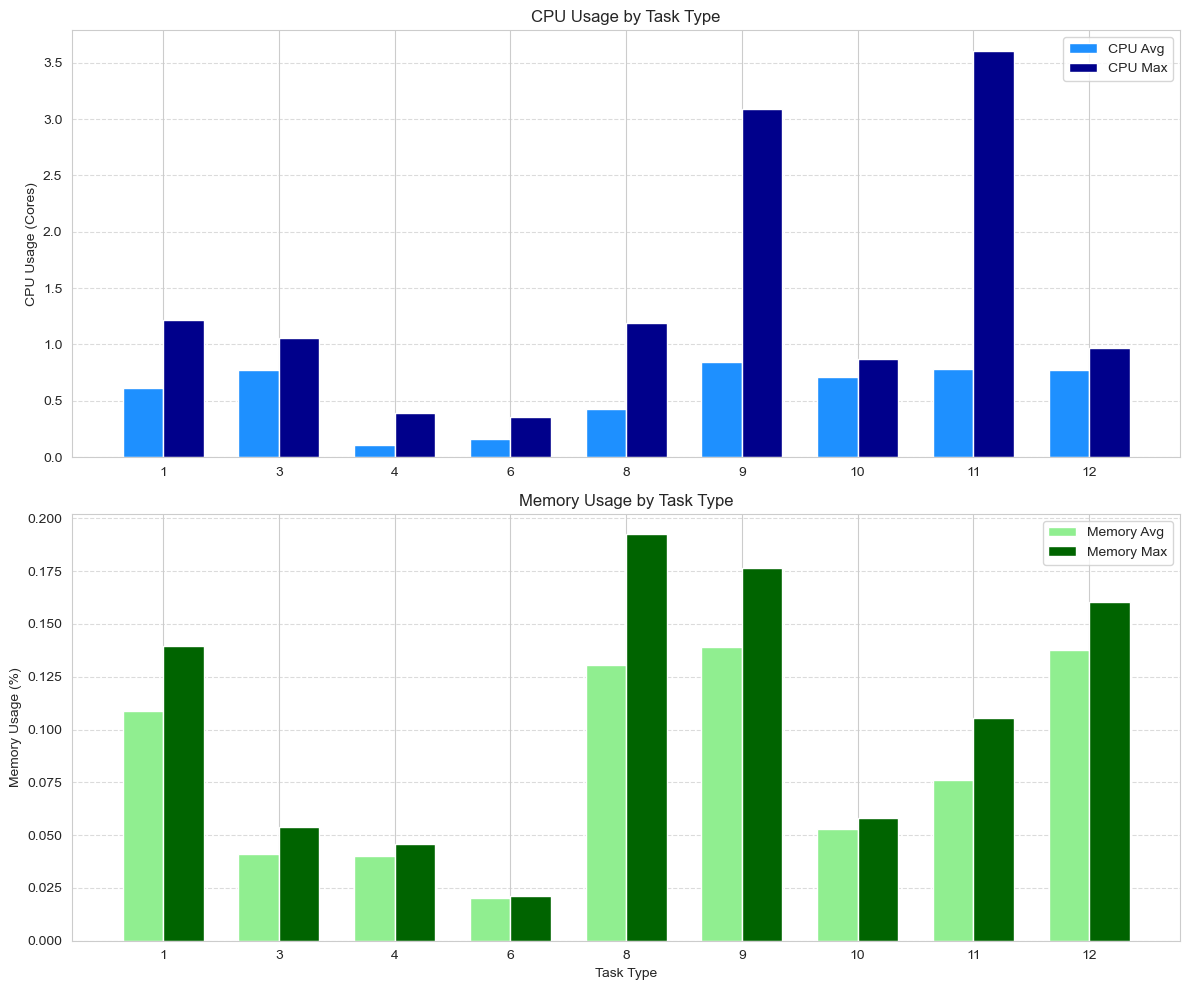

In [200]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
x = np.arange(len(task_type_resource_util.index))
width = 0.35

ax1.bar(x - width/2, task_type_resource_util['cpu_avg'], width, label='CPU Avg', color='dodgerblue')
ax1.bar(x + width/2, task_type_resource_util['cpu_max'], width, label='CPU Max', color='darkblue')
ax1.set_ylabel('CPU Usage (Cores)')
ax1.set_title('CPU Usage by Task Type')
ax1.set_xticks(x)
ax1.set_xticklabels(task_type_resource_util.index)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.bar(x - width/2, task_type_resource_util['mem_avg'], width, label='Memory Avg', color='lightgreen')
ax2.bar(x + width/2, task_type_resource_util['mem_max'], width, label='Memory Max', color='darkgreen')
ax2.set_xlabel('Task Type')
ax2.set_ylabel('Memory Usage (%)')
ax2.set_title('Memory Usage by Task Type')
ax2.set_xticks(x)
ax2.set_xticklabels(task_type_resource_util.index)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('alibaba_plots/alibaba_task_resource_usage.png')
plt.show()